[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/cheminformatics-workflow/notebooks/12-Activity_cliff.ipynb)

# Activity Cliff

Sometimes SAR analysis has less focous on simplicity of chemical transformation between compounds and more about the overall similarity (e.g., two compounds that differ in one atom of aromatic ring). A concept that encompassess such approach is called **Structure-Activity landscape**, where proximity of compounds is determined by their similarity and steepness is determined by differences in their acivity. If the pair (i,j) has high similarity and drastic difference in activity (A), then this pair forms an **Activity cliff**. The most common way to quantify the steepness of Activity Cliff is to use the <u>**Structure-Activity Landscape index (SALI)**</u>

In summary: The Structure-Activity Landscape Index (SALI) is used to understand the relationship between the structural similarity of compounds and their biological activities, helping to identify activity cliffs.


### **SALI equations**

#### 1. SALI from Euclidean Distance
Let $E_{ij}$ be the Euclidean distance between compounds $i$ and $j$, and $A_i$ and $A_j$ be their respective activities. The SALI can be calculated as:

$$
\text{SALI}_{ij} = \frac{|A_i - A_j|}{E_{ij}}
$$

#### 2. SALI from Tanimoto Similarity
Let $T_{ij}$ be the Tanimoto similarity between compounds $i$ and $j$. The SALI can be calculated as:

$$
\text{SALI}_{ij} = \frac{|A_i - A_j|}{1 - T_{ij}}
$$

#### 3. SALI from Maximum Common Substructure (MCS)
Let $M_{ij}$ be the size (number of atoms or bonds) of the MCS between compounds $i$ and $j$, and $S_i$ and $S_j$ be the sizes of the compounds $i$ and $j$. A normalized MCS size can be calculated as:

$$
\text{Normalized MCS}_{ij} = \frac{2 \cdot M_{ij}}{S_i + S_j}
$$

The SALI can then be calculated as:

$$
\text{SALI}_{ij} = \frac{|A_i - A_j|}{1 - \text{Normalized MCS}_{ij}}
$$


### **Setting a Threshold for SALI**

To identify significant activity cliffs in a dataset, you can set a threshold for the Structure-Activity Landscape Index (SALI). Here is a systematic approach to define this threshold:

1. **Calculate All SALI Values**:
   Compute SALI for all possible pairs of compounds in the dataset.
   
2. **Statistical Analysis**:
   Perform a statistical analysis of the SALI values to understand their distribution. Calculate measures like mean and standard deviation.
   
   - Mean(SALI): The average of all SALI values.
   - StdDev(SALI): The standard deviation of all SALI values.
   
3. **Define Threshold**:
   Based on the statistical analysis, define the threshold for identifying activity cliffs.
   
   $$
   \text{Threshold} = \text{Mean(SALI)} + k \cdot \text{StdDev(SALI)}
   \$$
  
   Where:
   - $k$ is a constant that determines the stringency of the threshold. A higher value of $k$ will result in a higher threshold, identifying only the most extreme activity cliffs.

   If $SALI({i,j})$ > Threshold, the the pair $i,j$ forms an activity cliff. Next, once can calculate the number of Activity Cliff formed by every compound in the dataset and analyze the data to estimate which compounds are outliers, i.e., are not characterized well with current descriptor space or tend to have no tolerance for modifications.
   
4. **Identify Activity Cliffs**:
   Use the threshold to identify activity cliffs in the dataset. Pairs of compounds with SALI values above this threshold are considered to have significant differences in activity given their structural similarity.
   
5. **Validation**:
   Validate the results by manually inspecting some of the identified pairs of compounds to ensure that they make sense in the context of the study.

## Content

1. [Load Libraries](#1)
2. [Load Data](#2)
3. [SALI MATRIX - Euclidean Distance](#3)
    - 3.1 [Changing the Threshold](#4)

## 1. Load Libraries<a name = 1></a>

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 45.6 MB/s eta 0:00:00


In [ ]:
!pip install mols2grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
import stat
import copy
import matplotlib.pyplot as plt

#--------------------------------------------------------------

from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
import mols2grid

#--------------------------------------------------------------

import sklearn.metrics

## 2. Load Datasets<a name = 2></a>

In [ ]:
data = PandasTools.LoadSDF('AID_1259247_sanitized.sdf', molColName='Molecule')

In [ ]:
data.head()

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),ID,Molecule
0,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...,Active,active antagonist,inactive,-37.5702,,<rdkit.Chem.rdchem.Mol object at 0x7985580d4970>
1,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O,Active,active antagonist,inactive,-37.9252,,<rdkit.Chem.rdchem.Mol object at 0x7985580d49e0>
2,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...,Active,active antagonist,inactive,-35.847,,<rdkit.Chem.rdchem.Mol object at 0x7985580d4a50>
3,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...,Active,active antagonist,inactive,-35.5194,,<rdkit.Chem.rdchem.Mol object at 0x7985580d4b30>
4,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2,Active,active antagonist,inactive,-39.4007,,<rdkit.Chem.rdchem.Mol object at 0x7985580d4c10>


In [ ]:
len(data)

5134

In [ ]:
data['Antagonist Efficacy (%)'] = data['Antagonist Efficacy (%)'].astype('float64')

In [ ]:
fingerprints = pd.read_csv('/content/morgan_fps.csv',  )
fingerprints.head()

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),ID,Molecule,Col_0,Col_1,Col_2,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...,Active,active antagonist,inactive,-37.5702,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2c00>,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O,Active,active antagonist,inactive,-37.9252,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2e30>,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...,Active,active antagonist,inactive,-35.8470,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2ea0>,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...,Active,active antagonist,inactive,-35.5194,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2f80>,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2,Active,active antagonist,inactive,-39.4007,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ddc51bc3060>,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
fingerprints.columns

Index(['PUBCHEM_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'Antagonist Activity',
       'Viability Activity', 'Antagonist Efficacy (%)', 'ID', 'Molecule',
       'Col_0', 'Col_1', 'Col_2',
       ...
       'Col_2038', 'Col_2039', 'Col_2040', 'Col_2041', 'Col_2042', 'Col_2043',
       'Col_2044', 'Col_2045', 'Col_2046', 'Col_2047'],
      dtype='object', length=2055)

In [ ]:
fingerprints.drop(['PUBCHEM_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'Antagonist Activity',
       'Viability Activity', 'Antagonist Efficacy (%)', 'ID', 'Molecule'], axis = 1, inplace = True)

In [ ]:
fingerprints

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5130,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5132,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_fnps = pd.concat([data, fingerprints], axis=1)
data_fnps.drop('ID', axis = 1, inplace = True)
data_fnps.head()

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),Molecule,Col_0,Col_1,Col_2,Col_3,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...,Active,active antagonist,inactive,-37.5702,<rdkit.Chem.rdchem.Mol object at 0x7985580d4970>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O,Active,active antagonist,inactive,-37.9252,<rdkit.Chem.rdchem.Mol object at 0x7985580d49e0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...,Active,active antagonist,inactive,-35.8470,<rdkit.Chem.rdchem.Mol object at 0x7985580d4a50>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...,Active,active antagonist,inactive,-35.5194,<rdkit.Chem.rdchem.Mol object at 0x7985580d4b30>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2,Active,active antagonist,inactive,-39.4007,<rdkit.Chem.rdchem.Mol object at 0x7985580d4c10>,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


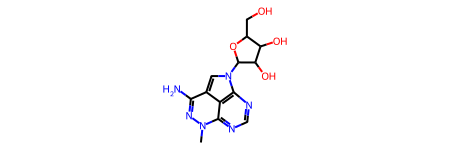

In [ ]:
data_fnps['Molecule'][0]

## 3. SALI MATRIX - Euclidean Distance<a name = 3></a>

In [ ]:
Dist_mat = sklearn.metrics.pairwise.euclidean_distances(fingerprints)
Dist_mat.round(2)

array([[0.  , 8.89, 6.86, ..., 7.48, 8.49, 8.49],
       [8.89, 0.  , 8.72, ..., 6.86, 8.06, 8.06],
       [6.86, 8.72, 0.  , ..., 7.28, 8.43, 8.43],
       ...,
       [7.48, 6.86, 7.28, ..., 0.  , 6.63, 6.63],
       [8.49, 8.06, 8.43, ..., 6.63, 0.  , 4.47],
       [8.49, 8.06, 8.43, ..., 6.63, 4.47, 0.  ]])

In [ ]:
len(Dist_mat)

5134

In [ ]:
len(fingerprints)

5134

In [ ]:
SALI_matrix = np.full((len(fingerprints), len(fingerprints)), 0, dtype='float64')

for i in range(len(fingerprints)):
    for j in range(i+1, len(fingerprints)):  # start from i+1 to avoid duplicate calculations and self-comparisons
        if Dist_mat[i, j] != 0: # Avoid division by zero
            SALI_matrix[i, j] = round(abs(data['Antagonist Efficacy (%)'][i] - data['Antagonist Efficacy (%)'][j]) / Dist_mat[i, j], 5)
        SALI_matrix[j, i] = SALI_matrix[i, j]  # since the matrix is symmetric

In [ ]:
SALI_matrix.round(2)

array([[0.  , 0.04, 0.25, ..., 5.02, 4.43, 4.43],
       [0.04, 0.  , 0.24, ..., 5.53, 4.7 , 4.7 ],
       [0.25, 0.24, 0.  , ..., 4.92, 4.25, 4.25],
       ...,
       [5.02, 5.53, 4.92, ..., 0.  , 0.  , 0.  ],
       [4.43, 4.7 , 4.25, ..., 0.  , 0.  , 0.  ],
       [4.43, 4.7 , 4.25, ..., 0.  , 0.  , 0.  ]])

In [ ]:
x = np.unique(SALI_matrix)
x.round(2)

array([0.000e+00, 0.000e+00, 1.000e-02, ..., 1.489e+01, 1.509e+01,
       1.594e+01])

In [ ]:
np.isnan(SALI_matrix)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
np.isinf(SALI_matrix)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
np.where(np.isinf(SALI_matrix))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
np.where(np.isnan(SALI_matrix))

(array([], dtype=int64), array([], dtype=int64))

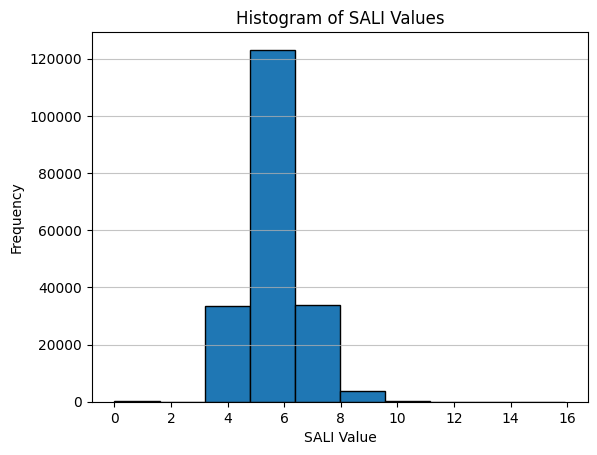

In [ ]:
# assess distribution vizually

# Convert the SALI matrix to a DataFrame
SALI_df = pd.DataFrame(SALI_matrix)

# Flatten the DataFrame and filter out the diagonal values (which are all 0)
SALI_values = SALI_df.values.flatten()
SALI_values = SALI_values[SALI_values != 0]

# Create a histogram
plt.hist(SALI_values, bins=10, edgecolor='k')
plt.title('Histogram of SALI Values')
plt.xlabel('SALI Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.savefig('SALI_distribution.pdf', bbox_inches='tight')
plt.show()

In [ ]:
np.mean(SALI_matrix)

0.04141714496526198

In [ ]:
np.std(SALI_matrix)

0.4874511567568538

A very big std deviation implies losing a lot activity cliffs. It's better to decrease it.
If the mean is bigger than the std deviation, then there's also a problem.

In [ ]:
# Define a threshold

threshold = np.mean(SALI_matrix) + 16*np.std(SALI_matrix)
threshold

7.840635653074923

In [ ]:
# Get the Cliffs

AC_matrix = SALI_matrix > threshold
len(AC_matrix)

5134

In [ ]:
np.sum(AC_matrix, axis = 1)

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
AC_df = pd.DataFrame(np.sum(AC_matrix, axis = 1), columns=['Num of Activity Cliffs'])

In [ ]:
AC_df

,Num of Activity Cliffs
0,0
1,0
2,0
3,1
4,78
...,...
5129,1
5130,0
5131,2
5132,0


In [ ]:
AC_df['SMILES'] = data['PUBCHEM_SMILES']
AC_df

,Num of Activity Cliffs,SMILES
0,0,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...
1,0,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O
2,0,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...
3,1,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...
4,78,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
...,...,...
5129,1,C(/C=C\Cl)Cl
5130,0,CC(C)OP(OC(C)C)OC(C)C
5131,2,C1CCSC1
5132,0,CN(CCCC(C1=CN=CC=C1)O)N=O


In [ ]:
mols2grid.display(AC_df, subset=['Num of Activity Cliffs'])

MolGridWidget()

In [ ]:
np.where(SALI_matrix[14, :] > threshold) #comparision for compound 14

(array([ 318, 1074]),)

-39.4897


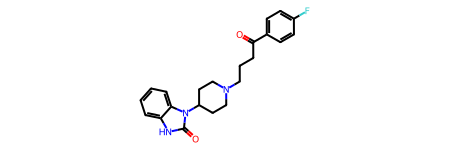

In [ ]:
print(data['Antagonist Efficacy (%)'][14])
data['Molecule'][14]

0.0


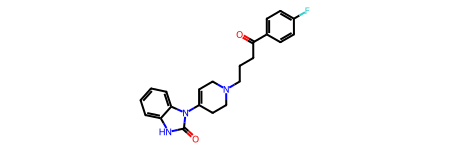

In [ ]:
print(data['Antagonist Efficacy (%)'][318])
data['Molecule'][318]

0.0


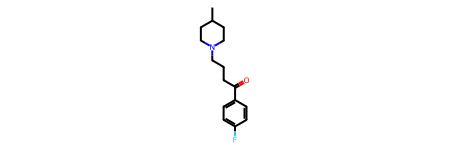

In [ ]:
print(data['Antagonist Efficacy (%)'][1074])
data['Molecule'][1074]

In [ ]:
mols = data.loc[[14, 318, 1074]]
mols

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),ID,Molecule
14,C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(=O)C4=CC=C(C=...,Active,active antagonist,inactive,-39.4897,,<rdkit.Chem.rdchem.Mol object at 0x7985580d51c0>
318,C1CN(CC=C1N2C3=CC=CC=C3NC2=O)CCCC(=O)C4=CC=C(C...,Inactive,inactive,inactive,0.0000,,<rdkit.Chem.rdchem.Mol object at 0x798558132ce0>
1074,CC1CCN(CC1)CCCC(=O)C2=CC=C(C=C2)F,Inactive,inactive,inactive,0.0000,,<rdkit.Chem.rdchem.Mol object at 0x798557cdbca0>


14     -39.4897
318      0.0000
1074     0.0000
Name: Antagonist Efficacy (%), dtype: float64


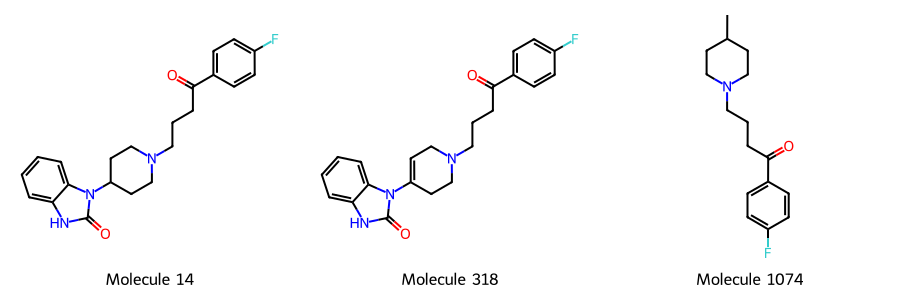

In [ ]:
# Print Inhibition percentages
print(mols['Antagonist Efficacy (%)'])

# Visualize selected molecules
legends = [f"Molecule {i}" for i in mols.index]
Draw.MolsToGridImage(mols['Molecule'], subImgSize=(300,300), legends=legends)

### Changing the Threshold<a name = 4></a>

In [ ]:
# Define a threshold

threshold_2 = np.mean(SALI_matrix) + 14*np.std(SALI_matrix)
threshold_2

6.865733339561215

In [ ]:
# Get the Cliffs

AC_matrix_2 = SALI_matrix > threshold_2
AC_matrix_2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
AC_df_2 = pd.DataFrame(np.sum(AC_matrix_2, axis = 1), columns=['Num of Activity Cliffs'])

In [ ]:
AC_df_2

,Num of Activity Cliffs
0,1
1,0
2,2
3,2
4,518
...,...
5129,2
5130,3
5131,4
5132,0


In [ ]:
AC_df_2['SMILES'] = AC_df_2.index.map(data['PUBCHEM_SMILES'])


In [ ]:
AC_df_2

,Num of Activity Cliffs,SMILES
0,1,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...
1,0,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O
2,2,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...
3,2,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...
4,518,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
...,...,...
5129,2,C(/C=C\Cl)Cl
5130,3,CC(C)OP(OC(C)C)OC(C)C
5131,4,C1CCSC1
5132,0,CN(CCCC(C1=CN=CC=C1)O)N=O


In [ ]:
mols2grid.display(AC_df_2, subset=['Num of Activity Cliffs'])

MolGridWidget()

In [ ]:
np.where(SALI_matrix[14, :] > threshold_2) #comparision for compound 14

(array([ 318,  333, 1074, 4755]),)

-39.4897


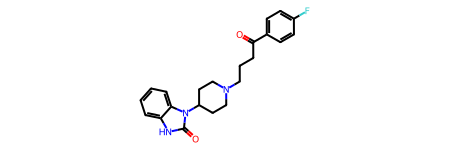

In [ ]:
print(data['Antagonist Efficacy (%)'][14])
data['Molecule'][14]

0.0


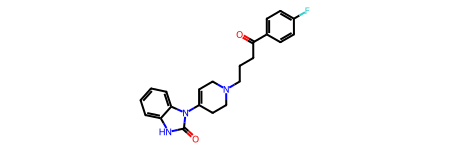

In [ ]:
print(data['Antagonist Efficacy (%)'][318])
data['Molecule'][318]

In [ ]:
print(data['Antagonist Efficacy (%)'][333])
data['Molecule'][333]

0.0


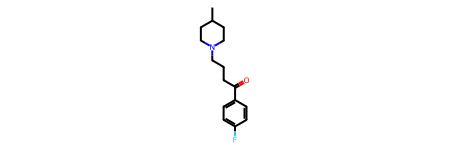

In [ ]:
print(data['Antagonist Efficacy (%)'][1074])
data['Molecule'][1074]

0.0


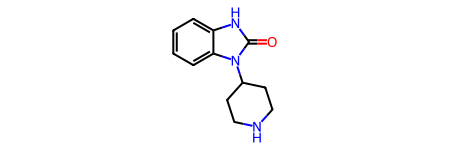

In [ ]:
print(data['Antagonist Efficacy (%)'][4755])
data['Molecule'][4755]

In [ ]:
mols_2 = data.loc[[14, 318, 333, 1074, 4755]]
mols_2

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),ID,Molecule
14,C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(=O)C4=CC=C(C=...,Active,active antagonist,inactive,-39.4897,,<rdkit.Chem.rdchem.Mol object at 0x7985580d51c0>
318,C1CN(CC=C1N2C3=CC=CC=C3NC2=O)CCCC(=O)C4=CC=C(C...,Inactive,inactive,inactive,0.0000,,<rdkit.Chem.rdchem.Mol object at 0x798558132ce0>
333,C1CN(CCN1CCCC(=O)C2=CC=C(C=C2)F)C3=CC=CC=N3,Inactive,inactive,inactive,0.0000,,<rdkit.Chem.rdchem.Mol object at 0x7985581334c0>
1074,CC1CCN(CC1)CCCC(=O)C2=CC=C(C=C2)F,Inactive,inactive,inactive,0.0000,,<rdkit.Chem.rdchem.Mol object at 0x798557cdbca0>
4755,C1CNCCC1N2C3=CC=CC=C3NC2=O,Inactive,inactive,inactive,0.0000,,<rdkit.Chem.rdchem.Mol object at 0x7985577859a0>


14     -39.4897
318      0.0000
333      0.0000
1074     0.0000
4755     0.0000
Name: Antagonist Efficacy (%), dtype: float64


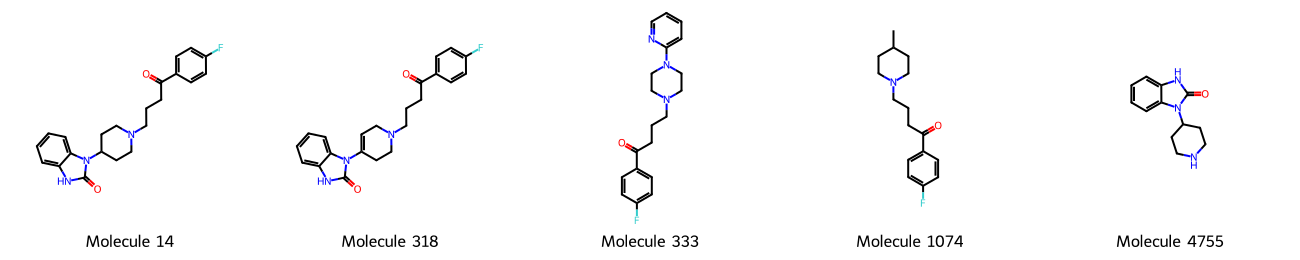

In [ ]:
# Print Inhibition percentages
print(mols_2['Antagonist Efficacy (%)'])

legends = [f"Molecule {i}" for i in mols_2.index]
# Visualize selected molecules
Draw.MolsToGridImage(mols_2['Molecule'], subImgSize=(260,260), molsPerRow=5, legends=legends)